In [1]:
import pandas as pd
import numpy as np
from Scaling import standardize, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from MetricsRFC import create_roc_curve, evaluate_rfc

In [2]:
df2015 = pd.read_csv('../data/kaasa/kaasa_2015.csv', index_col=None, header=0)
df2016 = pd.read_csv('../data/kaasa/kaasa_2016.csv', index_col=None, header=0)
df2017 = pd.read_csv('../data/kaasa/kaasa_2017.csv', index_col=None, header=0)
df2018 = pd.read_csv('../data/kaasa/kaasa_2018.csv', index_col=None, header=0)
df2019 = pd.read_csv('../data/kaasa/kaasa_2019.csv', index_col=None, header=0)
df2020 = pd.read_csv('../data/kaasa/kaasa_2020.csv', index_col=None, header=0)
df2021 = pd.read_csv('../data/kaasa/kaasa_2021.csv', index_col=None, header=0)

all_files = [df2015, df2016, df2017, df2018, df2019, df2020, df2021]

df = pd.concat(all_files, axis=0, ignore_index=True)

df = df.drop(columns=['source_id', 'individual', 'owner_id', 'name',  'distance', 'sin_time', 'cos_time', 'date_time',
                      'longitude', 'latitude', 'temperature', 'altitude'])

df = standardize(df, ['velocity', 'angle']) # standarize the data
df = normalize(df, ['velocity', 'angle'], 0, 1) # normalize the data

X = df.drop(['attack'], axis=1) # Features
y = df['attack'] # Target variable

# Determine the optimal split between the training and test set
Use a technique called cross-validation

In [41]:
from sklearn.model_selection import cross_val_score, train_test_split

# Set up the random forest model
model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

# Define the training and testing set sizes you want to try
train_sizes = [0.8, 0.9]

# Loop over the different training set sizes
for train_size in train_sizes:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y)
    
    # Perform cross-validation with 5 folds
    scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Print the average cross-validation score for this training set size
    print(f"Training set size: {train_size:.1f}, Cross-validation score: {np.mean(scores):.3f}")
    
    # Train the model on the entire training set and evaluate on the testing set
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    # Print the testing set score
    print(f"Training set size: {train_size:.1f}, Testing set score: {test_score:.3f}")


Training set size: 0.8, Cross-validation score: 0.980
Training set size: 0.8, Testing set score: 0.980
Training set size: 0.9, Cross-validation score: 0.979
Training set size: 0.9, Testing set score: 0.980


# Trying different sampling techniques
Features are velocity and trajectory angle

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('attack', axis=1), df['attack'], test_size=0.1, random_state=42, stratify=y)

## No sampling technique

In [46]:
# Create a random forest classifier model
rf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

roc_auc_score for RandomForestClassifier:  0.5036899080462097
Best threshold: 1


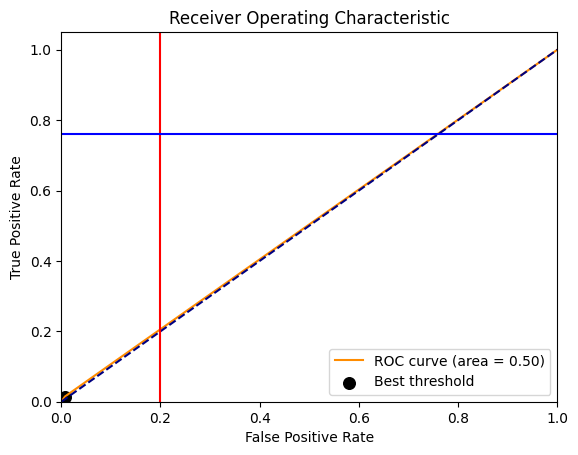

Accuracy: 97.88 %
[[23437   174]
 [  334     5]]
              precision    recall  f1-score   support

           0      0.986     0.993     0.989     23611
           1      0.028     0.015     0.019       339

    accuracy                          0.979     23950
   macro avg      0.507     0.504     0.504     23950
weighted avg      0.972     0.979     0.976     23950



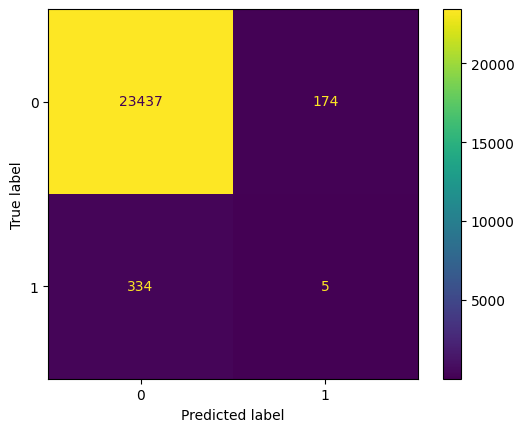

In [47]:
create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

## Undersampling
In undersampling, you randomly remove some of the majority class instances to balance the dataset.

In [48]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Train the Random Forest Classifier on the balanced dataset
rf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

roc_auc_score for RandomForestClassifier:  0.504493368360255
Best threshold: 1


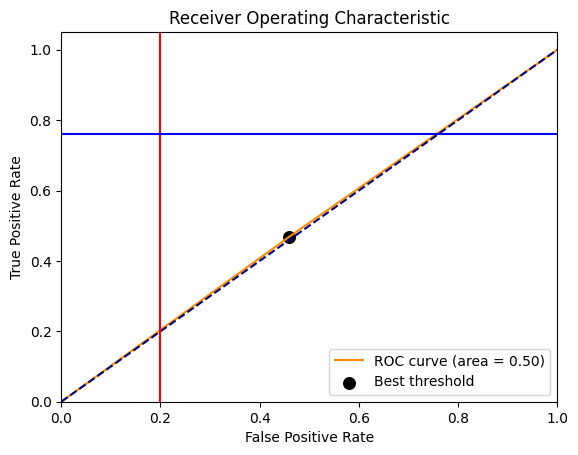

Accuracy: 53.9 %
[[12749 10862]
 [  180   159]]
              precision    recall  f1-score   support

           0      0.986     0.540     0.698     23611
           1      0.014     0.469     0.028       339

    accuracy                          0.539     23950
   macro avg      0.500     0.504     0.363     23950
weighted avg      0.972     0.539     0.688     23950



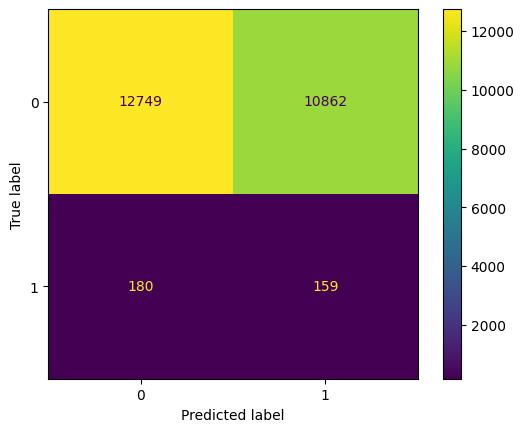

In [49]:
create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

In [ ]:
# Use if you want to adjust the treshold of what to label as positive
y_prob = rf.predict_proba(X_test)[:, 1] # Probabilities of positive class
y_pred = (y_prob > 0.5).astype(int) # Adjusting threshold to 0.5

## Oversampling
Increase the number of instances from the minority class by replicating them

In [50]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Train the Random Forest Classifier on the balanced dataset
rf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# Make predictions on the testing set
y_pred = rf.predict(X_test)

roc_auc_score for RandomForestClassifier:  0.5019110761458243
Best threshold: 1


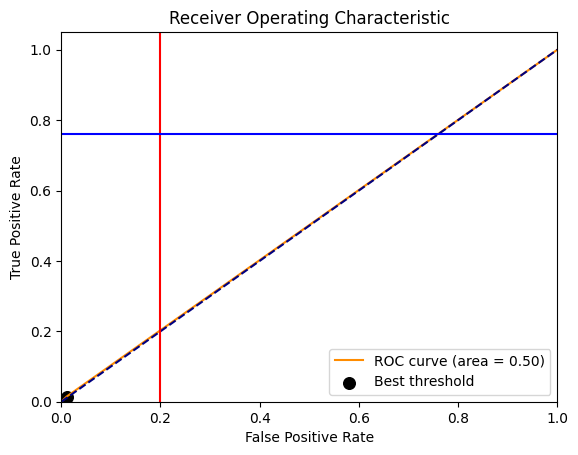

Accuracy: 97.53 %
[[23353   258]
 [  334     5]]
              precision    recall  f1-score   support

           0      0.986     0.989     0.987     23611
           1      0.019     0.015     0.017       339

    accuracy                          0.975     23950
   macro avg      0.502     0.502     0.502     23950
weighted avg      0.972     0.975     0.974     23950



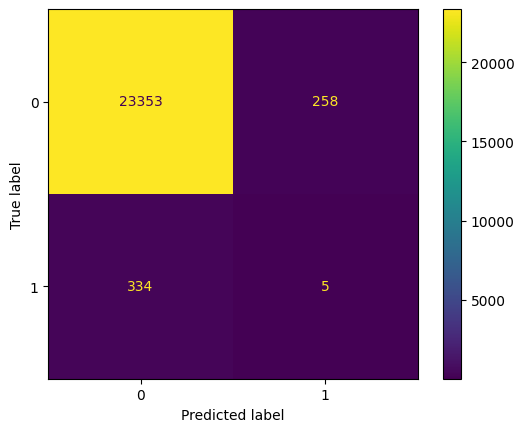

In [51]:
create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

## Combination of under- and oversampling
Using SMOTEENN: SMOTE + ENN. SMOTEENN combines these two techniques by first applying SMOTE to oversample the minority class and then using ENN to remove any noisy samples that were generated by SMOTE. The result is a balanced dataset that is less noisy than a dataset generated by SMOTE alone. ENN removes instances from both classes.

In [52]:
from imblearn.combine import SMOTEENN

# Define the combined sampling method
sampler = SMOTEENN(random_state=42)

# Fit and apply the sampling method to the training data
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

# Train a random forest classifier on the resampled data
rf = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf.predict(X_test)

roc_auc_score for RandomForestClassifier:  0.48727606713984745
Best threshold: 2


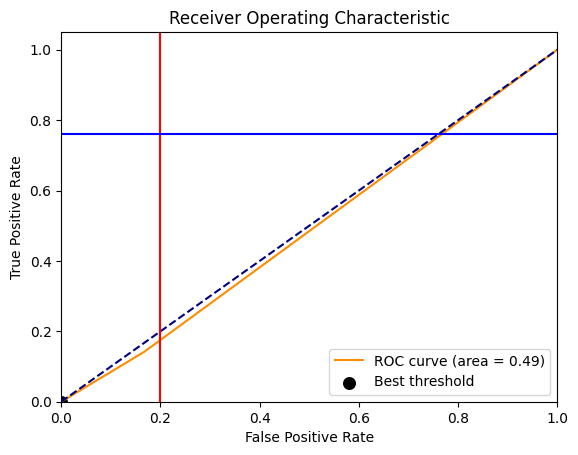

Accuracy: 82.32 %
[[19667  3944]
 [  291    48]]
              precision    recall  f1-score   support

           0      0.985     0.833     0.903     23611
           1      0.012     0.142     0.022       339

    accuracy                          0.823     23950
   macro avg      0.499     0.487     0.462     23950
weighted avg      0.972     0.823     0.890     23950



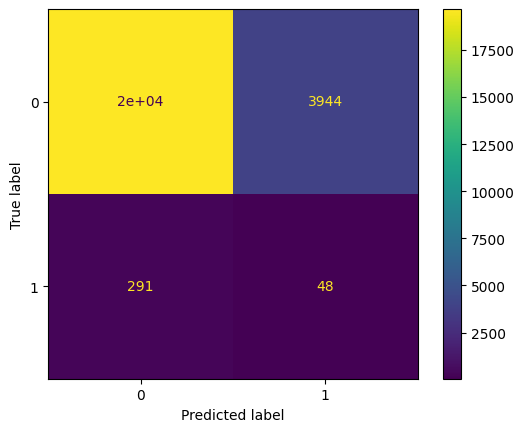

In [53]:
create_roc_curve(y_test, y_pred)
evaluate_rfc(rf, y_test, y_pred)

## Advanced oversampling SMOTE
SMOTE is oversampling the minority class. It generates synthetic examples of the minority class by interpolating between existing minority class instances. 

In [54]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to oversample the minority class
oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Build SMOTE SRF model
SMOTE = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)

SMOTE.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = SMOTE.predict(X_test)

roc_auc_score for RandomForestClassifier:  0.4946511356825958
Best threshold: 2


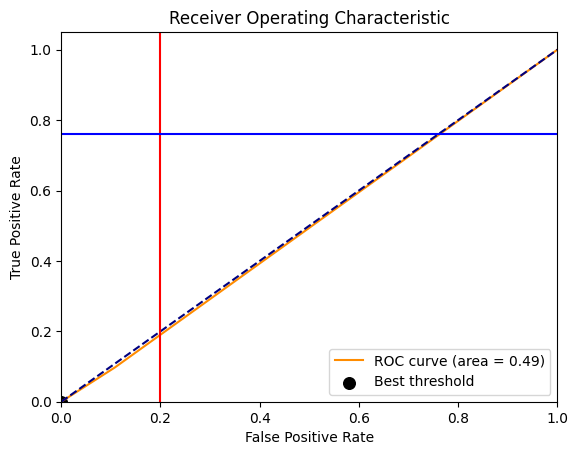

Accuracy: 88.07 %
[[21060  2551]
 [  306    33]]
              precision    recall  f1-score   support

           0      0.986     0.892     0.936     23611
           1      0.013     0.097     0.023       339

    accuracy                          0.881     23950
   macro avg      0.499     0.495     0.480     23950
weighted avg      0.972     0.881     0.924     23950



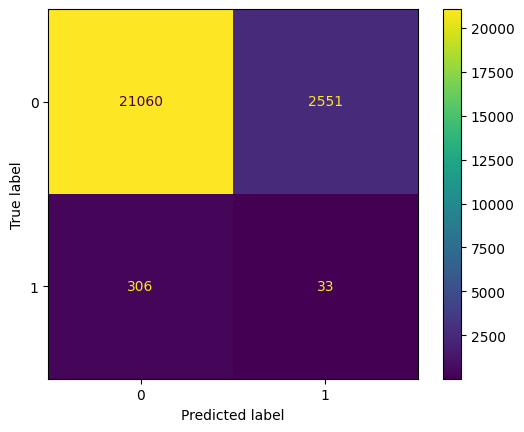

In [55]:
create_roc_curve(y_test, y_pred)
evaluate_rfc(SMOTE, y_test, y_pred)